In [26]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.tree import DecisionTreeClassifier

In [4]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [ ]:
# list(df_train.columns)

In [ ]:
# train_transaction.head() # KEEP

In [ ]:
# train_identity.head() # KEEP

In [ ]:
# train_transaction.info(); # KEEP

In [ ]:
# train_identity.info(); # KEEP

#### Data Quality Check

In [ ]:
# KEEP
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

In [ ]:
df_train.isnull().any()

In [ ]:
df_train.info()

In [ ]:
df_train.dtypes()

#### EDA

In [27]:
# How many transactions are is the dataset?
df_train.shape

(590540, 220)

In [32]:
# What is the fraud rate of the data set?
fraud_rate = df_train.isFraud.value_counts() / 590540
fraud_rate

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

In [29]:
# What is the statistical overview of the data set?
df_train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,addr1,addr2,C1,C2,C3,C4,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,...,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,165.493264,65.854435,14.092458,15.269734,0.005644,4.092185,...,39.173114,21.305592,43.226087,26.749372,109.816313,247.601710,162.150103,18.372102,42.072278,28.326009
std,1.704744e+05,0.183755,4.617224e+06,239.162522,93.696289,3.546653,133.569018,154.668899,0.150536,68.848459,...,172.126681,95.804974,173.443984,116.734202,2270.010192,3980.002546,2793.315350,332.301482,473.494534,382.049311
min,2.987000e+06,0.000000,8.640000e+04,0.251000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,79.000000,65.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,151.000000,65.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,250.000000,65.000000,3.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,332.000000,74.000000,4685.000000,5691.000000,26.000000,2253.000000,...,55125.000000,4817.470215,7519.870117,4817.470215,93736.000000,134021.000000,98476.000000,104060.000000,104060.000000,104060.000000


In [48]:
fraud_summary = df_train.groupby('isFraud')
fraud_summary.mean()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,C1,C2,C3,C4,C5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
isFraud,,,,,,,,,,,,,,,,,,,,,
0,3.281810e+06,7.360791e+06,134.511665,163.642265,65.776543,13.314952,14.173283,0.005840,3.693878,5.722537,...,37.941626,20.549558,41.955015,25.677123,111.096134,243.805877,161.620207,18.368309,41.625136,28.204085
1,3.294952e+06,7.690033e+06,149.244779,216.543048,68.002662,35.535740,45.509413,0.000242,15.077336,1.406717,...,73.137039,42.156677,78.281729,56.321550,74.519367,352.289202,176.764416,18.476726,54.404279,31.688605


In [49]:
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_groupby.csv')

### Assigning columns to specific lists (cat, num, date, etc.)

In [5]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [6]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
                
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info

# determine what to do with columns that have too many unique values... obviously.. types of solutions
# would be to put "MISSING" for those that dont have an email address... but you will need to evaluate 
# and make instead a counter of unique values, then append that and look at the CSV via google sheets. use 
# something like the code below 

# Planning - our preprocessing method must automatically drop missing values, but we can't do that because
# we need to see about filling them in first, then decide if we need to drop them. Right now, we need to
# create a dataframe that shows unique values for each column with missing values. 

# we need to look at each variable and see if it's unique or categorical. We need to use possibly PCA...? How do
# we handle so many variables? 

There were 195 columns with null values.


In [7]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

label encoded: addr1 unique 333
label encoded: addr2 unique 75
dummies encoded: ProductCD unique 5
dummies encoded: P_emaildomain unique 59
label encoded: card1 unique 13553
label encoded: card2 unique 501
label encoded: card3 unique 115
dummies encoded: card4 unique 4
label encoded: card5 unique 120
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 285)


In [8]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

In [ ]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

corr = df_features.corr()
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
plt.show()
corr2

In [ ]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.show()

# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
###########
# y_test = pp.df_train[col_target] #.rename(columns=['isFraud'])
# y_test = pd.Series(y_test)
# y_test

In [ ]:
# # Testing dropping columns
# model_lr_results = pd.DataFrame()
# model_recall = []
# model_precision = []
# model_auc_score = []

# for col in ['addr1', 'addr2', 'P_emaildomain', 'card1', 'card2', 'card3', 'card5']:
#     print('Dropping: ', col)
#     X_drop = X.drop(col, axis=1)
# #     X_drop = X_drop.loc[:10000,:]
#     y_drop = y#[:10001]
    
#     scaled_X = StandardScaler().fit_transform(X_drop)
#     # pca
#     pca = PCA()
#     pcomponents = pca.fit_transform(scaled_X)
#     X_pca = pd.DataFrame(data=pcomponents)
#     # split
#     X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y_drop, test_size=0.1, random_state=42)
#     # smote
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
#     X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)
#     # model fit
#     model_lr_pca = LogisticRegression(random_state=42)
#     model_lr_pca.fit(X_train_res, y_train_res)
#     # predict
#     y_pred_prob = model_lr_pca.predict_proba(X_pca)
#     y_pred_class = binarize(y_pred_prob, 0.5)[:,1]
#     # scoring
#     model_recall.append(recall_score(y_drop, y_pred_class))
#     model_precision.append(precision_score(y_drop, y_pred_class))
#     model_auc_score.append(roc_auc_score(y_drop, y_pred_prob[:,1]))
#     print(confusion_matrix(y_drop, y_pred_class))
#     print(classification_report(y_drop, y_pred_class))
#     print('AUC: ', roc_auc_score(y_drop, y_pred_prob[:,1]))

# model_recall = pd.Series(model_recall, name='recall')
# model_precision = pd.Series(model_precision, name='precision')
# model_auc_score = pd.Series(model_auc_score, name='auc_score')
# model_results_final = pd.concat([model_auc_score, model_recall, model_precision],axis=1)
# model_results_final

# # it's apparent that label encoding on some of these don't really matter and if we drop them.. it doesn't really
# # matter.. 
# # dropping these columns has little impact with logistic regression.. 

# # tune logistic regression

In [ ]:
### DELETE

# model_lr_results = pd.DataFrame()
# model_recall = []
# model_precision = []
# model_auc_score = []

#     model_recall.append(recall_score(y_drop, y_pred_class))
#     model_precision.append(precision_score(y_drop, y_pred_class))
#     model_auc_score.append(roc_auc_score(y_drop, y_pred_prob[:,1]))

# model_recall = pd.Series(model_recall, name='recall')
# model_precision = pd.Series(model_precision, name='precision')
# model_auc_score = pd.Series(model_auc_score, name='auc_score')
# model_results_final = pd.concat([model_auc_score, model_recall, model_precision],axis=1)
# model_results_final

In [ ]:
# ### DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

## Applying PCA (2 components)

In [ ]:
# standardizing our data, which is required for PCA.
scaled_X = StandardScaler().fit_transform(X)
pd.DataFrame(scaled_X, columns=X.columns).head()

In [ ]:
# PCA instantiate and fit 
pca = PCA(n_components=2)
pcomponents = pca.fit_transform(scaled_X)
X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
print(X_pca.shape)
X_pca.head()

In [ ]:
# two principal components scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

# explaining vaariance
print('Variance ratio:')
print(pca.explained_variance_ratio_)
# interpreting principal components
print('\nPrincipal components explained:')
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

## Applying PCA to all features (all components)

In [ ]:
pca2 = PCA().fit(scaled_X)
# pca2.explained_variance_ratio_
# np.cumsum(pca2.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Credit Card Fraud Explained Variance')
plt.show()

## Model w/ SMOTE only - base model

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Apply SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train1, y_train1)

In [ ]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_res, y_train_res) 

In [ ]:
# predicting on test set w/o PCA
print("Predicting using only SMOTE (and w/o PCA)\n")
y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr.score(X_test1, y_test1))
print(recall_score(y_test1, y_pred_test1))
print("\nConfusion Matrix")
print(confusion_matrix(y_test1, y_pred_test1))
print('\nClassification Report:\n')
print(classification_report(y_test1, y_pred_test1))

# predicting on original dataset
print("Whole dataset:")
y_pred = model_lr.predict(X)
print("\nTest Results")
print(model_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))

## Logistic Regression w/PCA  w/SMOTE

### EDA

In [ ]:
sns.lmplot(x='addr1', y='addr2', data=df_features,
           fit_reg=False, hue='isFraud')
plt.title('addr1 versus addr2')
plt.show()

sns.distplot(df_features.addr1)
plt.title('Addr1 Distribution')
plt.show()

# sns.distplot(df_features['addr3'])
# plt.title('Addr3 Distribution')
# plt.show()

# sns.lmplot(x='addr3', y='addr4', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr3 versus addr4')
# plt.show()

In [ ]:
# sns.distplot(df_features.addr2, kde=False)
# plt.show()
# df_features.addr2.value_counts(ascending=False)[:20]

In [ ]:
# for val in df_features.addr2.unique():
#     if df_features.addr2.loc[]

In [ ]:
# print(df_features.addr2.unique())
# df_features.addr2.sort_values(ascending=True)[:20]

In [ ]:
# list(df_train.columns)

In [ ]:
# EDA Email Class
# P_emaildomain
# list(df_train.columns)
# df_train.P_emaildomain.unique()
list_perc = []
list_fraud_count = []
list_non_fraud_count = []
for val in df_train.P_emaildomain.unique():
    non_fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==0)].shape[0]
    fraud_count = df_train[(df_train.P_emaildomain==val) & (df_train.isFraud==1)].shape[0]
    
    list_perc.append(fraud_count/non_fraud_count)
    
    list_fraud_count.append(fraud_count)
    list_non_fraud_count.append(non_fraud_count)
    
col_email = pd.Series(df_train.P_emaildomain.unique(), name='email')
col_perc = pd.Series(list_perc, name='fraud_perc')
col_fraud_count = pd.Series(list_fraud_count, name='fraud_count')
col_non_fraud_count = pd.Series(list_non_fraud_count, name='non_fraud_count')

# col_perc
df_email_fe = pd.concat([col_email, col_perc, col_fraud_count, col_non_fraud_count], axis=1)
# df_email_fe
# df_train[(df_train.P_emaildomain=='outlook.com') & (df_train.isFraud==1)].shape[0]

In [ ]:
sns.boxplot(df_email_fe.fraud_perc)

In [ ]:
# Hypothesis: less occurring email domains are more likely to have higher fraud_perc because they are 
# perhaps an email provider with less resources. The card that the holder has attached to certain email
# addresses puts them at higher risk for fraud. 

### Feature Engineering Class

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# # X = X.drop('addr1', axis=1)
# # X = X.drop('addr2', axis=1)
# y = df_features[col_target]

In [10]:
df_features['P_emaildomain_copy'] = df_train['P_emaildomain']
list_col = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5', 'P_emaildomain_copy']

class FeatureEngineering():
    '''create engineered features for columns without ordinal values'''
    def __init__(self, list_col):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self._create_feature()
        
    def _create_feature(self):
        '''main method that executes functions'''
        for col_val in list_col:
            self._calculate_fraud_perc(col_val, self.df_feat)
        self._map_col()
        self._create_ratio()
        self.df_feat = self.df_feat.drop(list_col, axis=1)
            
    def _calculate_fraud_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==1)].shape[0]
            non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
            if (non_fraud_total==0):
                list_perc.append(0)
            else: 
                list_perc.append(fraud_total/non_fraud_total)
        self._create_dict(col_val, list_perc, unique_col_values)

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for col, key in zip(list_col, dict_keys):
            self.df_feat[col + '_fe'] = self.df_feat[col].map(self.dict_all_feat[key])
            self.new_col.append(col + '_fe')
            
    def _create_ratio(self):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = self.df_feat[self.df_feat[val] > 0][val].min()
            self.df_feat[val] = self.df_feat[val]/col_min_val

fe = FeatureEngineering(list_col)
fe.df_feat

,TransactionID,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,...,M4_M1,M4_M2,M6_T,addr1_fe,addr2_fe,card1_fe,card2_fe,card3_fe,card5_fe,P_emaildomain_2_fe
0,2987000,0,86400,68.50,1.0,1.0,0.0,0.0,0.0,1.0,...,0,1,1,2.285776,1.0,169.393939,53.384489,2.946859,9.237736,13.592138
1,2987001,0,86401,29.00,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,1,3.288929,1.0,27.477727,74.807840,2.946859,13.703223,13.592138
2,2987002,0,86469,59.00,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,4.161296,1.0,4.577798,26.425206,2.946859,2.274288,34.577807
3,2987003,0,86499,50.00,2.0,5.0,0.0,0.0,0.0,4.0,...,0,0,0,4.120587,1.0,7.947229,17.790293,2.946859,2.822371,7.708132
4,2987004,0,86506,50.00,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,4.257885,1.0,32.882353,52.038936,2.946859,13.703223,13.592138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,2.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,3.711321,1.0,2.372666,53.384489,2.946859,6.204501,13.592138
590536,3577536,0,15811049,39.50,1.0,1.0,0.0,0.0,0.0,1.0,...,0,0,1,3.452078,1.0,0.000000,30.257699,2.946859,8.205715,13.592138
590537,3577537,0,15811079,30.95,1.0,1.0,0.0,0.0,1.0,1.0,...,0,0,1,3.720269,1.0,10.734121,19.364771,2.946859,8.205715,13.592138
590538,3577538,0,15811088,117.00,1.0,1.0,0.0,0.0,0.0,3.0,...,0,0,1,2.464734,1.0,14.695459,32.481951,2.946859,8.205715,7.380276


In [ ]:
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [110]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

X = fe.df_feat.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
# TESTING DROP FEATURES
X = X.drop(list_drop_col_1, axis=1)
y = df_features[col_target]
list(X.columns)

['TransactionDT',
 'TransactionAmt',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D10',
 'D11',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V28',
 'V29',
 'V30',
 'V31',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V51',
 'V52',
 'V53',
 'V55',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V111',
 'V112',
 'V113',
 'V11

In [99]:
# ### PCA + SMOTE testing algorithm ###
# import time
# start_time = time.time()
# # applying PCA
# scaled_X = StandardScaler().fit_transform(X)
# # pca = PCA(n_components=250)
# pca = PCA()
# pcomponents = pca.fit_transform(scaled_X)
# X_pca = pd.DataFrame(data=pcomponents)

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

# # applying SMOTE
# sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
# X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

# # fit logistic regression
# model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_pca_sm.fit(X_train_res, y_train_res)
# # predict
# y_pred = model_lr_pca_sm.predict(X_train2)
# # time
# elapsed_time = time.time() - start_time
# print('\nTime elapsed:', elapsed_time / 60)
# print(confusion_matrix(y_train2, y_pred))
# print(classification_report(y_train2, y_pred))


Time elapsed: 58.90604650179545
[[413977  98955]
 [  4747  13807]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89    512932
           1       0.12      0.74      0.21     18554

    accuracy                           0.80    531486
   macro avg       0.56      0.78      0.55    531486
weighted avg       0.96      0.80      0.87    531486



In [111]:
# no PCA, SMOTE only
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.1, random_state=42)
import time
start_time = time.time()
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

# fit logistic regression
model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_pca_sm.fit(X_train_res, y_train_res)
# predict
y_pred = model_lr_pca_sm.predict(X_train2)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)
print(confusion_matrix(y_train2, y_pred))
print(classification_report(y_train2, y_pred))


Time elapsed: 2.534430682659149
[[237544 275388]
 [  3345  15209]]
              precision    recall  f1-score   support

           0       0.99      0.46      0.63    512932
           1       0.05      0.82      0.10     18554

    accuracy                           0.48    531486
   macro avg       0.52      0.64      0.36    531486
weighted avg       0.95      0.48      0.61    531486



In [70]:
# # fit logistic regression
# model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_pca_sm.fit(X_train_res, y_train_res)
# # predict
# y_pred = model_lr_pca_sm.predict(X_train2)
# # time
# elapsed_time = time.time() - start_time
# print('\nTime elapsed:', elapsed_time / 60)
# print(confusion_matrix(y_train2, y_pred))
# print(classification_report(y_train2, y_pred))


Time elapsed: 2.5606173157691954


In [ ]:
# RESULTS: NEXT, look at randys videos to figure out EDA and how we can uncover new potential features.. 

# RESULTS: dropped features and used PCA, worstened score
# [[413977  98955]
#  [  4747  13807]]
#               precision    recall  f1-score   support

#            0       0.99      0.81      0.89    512932
#            1       0.12      0.74      0.21     18554

#     accuracy                           0.80    531486
#    macro avg       0.56      0.78      0.55    531486
# weighted avg       0.96      0.80      0.87    531486
# RESULTS: drop low ranking features found in decision tree
# [[329812 183120]
#  [  4810  13744]]
#               precision    recall  f1-score   support

#            0       0.99      0.64      0.78    512932
#            1       0.07      0.74      0.13     18554

#     accuracy                           0.65    531486
#    macro avg       0.53      0.69      0.45    531486
# weighted avg       0.95      0.65      0.76    531486

# RESULTS: without PCA
# [[298715 214217]
#  [  3509  15045]]
#               precision    recall  f1-score   support

#            0       0.99      0.58      0.73    512932
#            1       0.07      0.81      0.12     18554

#     accuracy                           0.59    531486
#    macro avg       0.53      0.70      0.43    531486
# weighted avg       0.96      0.59      0.71    531486

# RESULTS: keep ohe for email and create p email feature calculate email domain fraud feature
# [[434421  78511]
#  [  4429  14125]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486

# RESULTS: with new feature, try dropping ohe p_email and test
# [[435499  77433]
#  [  4539  14015]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.85    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.85      0.89    531486

# RESULTS: cut FP rate quite a bit. fixing fraud perc calculation by doing fraud/non fraud for each value in each column
# [[434423  78509]
#  [  4430  14124]]
#               precision    recall  f1-score   support

#            0       0.99      0.85      0.91    512932
#            1       0.15      0.76      0.25     18554

#     accuracy                           0.84    531486
#    macro avg       0.57      0.80      0.58    531486
# weighted avg       0.96      0.84      0.89    531486


# RESULTS: adding 60 for one hot encoding
# [[403339 109593]
#  [  4393  14161]]
#               precision    recall  f1-score   support

#            0       0.99      0.79      0.88    512932
#            1       0.11      0.76      0.20     18554

#     accuracy                           0.79    531486
#    macro avg       0.55      0.77      0.54    531486
# weighted avg       0.96      0.79      0.85    531486

# RESULTS: fe for 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card5'
# [[397116 115816]
#  [  4490  14064]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.77      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: only addr6. Creating ratio ranking of higher risk areas for fraud. 
# [[396866 116066]
#  [  4534  14020]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# NEXT, test creating iqr range instead of percentage values, instead of what we did
# with addr5, then create one for addr2, then create an addr7 based on interaction with addr2. 



# RESULTS: only addr5. testing mapping percentage values transformed..
# [[396898 116034]
#  [  4535  14019]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr3, addr4
# [[396868 116064]
#  [  4544  14010]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: w/o addr1, addr2, addr3, addr4
# [[396629 116303]
#  [  4545  14009]]

#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr1, addr2
# [[396803 116129]
#  [  4555  13999]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with addr1, addf2, addr3, addr4
# [[396877 116055]
#  [  4549  14005]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

In [ ]:
# y_pred = model_lr_pca_sm.predict(X_pca)

# cross validation
# result = cross_val_score(model_lr_pca_sm, X_train2, y_train2, cv=10, n_jobs=-1, scoring='recall_score')
# result.mean()

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


### Predict Proba

In [ ]:
%matplotlib inline
plt.rcParams['font.size'] = 14

In [ ]:
y_pred_prob = model_lr_pca.predict_proba(X_pca)
plt.hist(y_pred_prob[:,1], bins=8)
plt.xlim(0,1)
plt.title("Histogram of Probability of Fraud")
plt.xlabel("Predicted probability of Fraud")
plt.ylabel("Frequency")

In [ ]:
y_pred_prob = model_lr_pca.predict_proba(X_pca)
y_pred_class = binarize(y_pred_prob, 0.5)[:,1]

In [ ]:
print(confusion_matrix(y, y_pred_class))
print(classification_report(y, y_pred_class))

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC curve for fraud detection classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

In [ ]:
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')

In [ ]:
evaluate_threshold(.5)
evaluate_threshold(.2)
evaluate_threshold(.1)

print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
print('y_pred_actual on test set\n')
print(y_pred_actual[0:10])
print(confusion_matrix(y_test2, y_pred_actual))
print(classification_report(y_test2, y_pred_actual))

print('y_pred_proba\n')
y_pred_proba = model_lr_pca.predict_proba(X_test2)
y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
print(y_pred_class[0:10])
print(confusion_matrix(y_test2, y_pred_class))
print(classification_report(y_test2, y_pred_class))

In [ ]:
y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
print('Logistic Regression')
print('y_pred_actual full data set\n')
print(y_pred_actual[0:10])
print(confusion_matrix(y, y_pred_actual))
print(classification_report(y, y_pred_actual))

print('y_pred_proba full data set\n')
y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
print(y_pred_class[0:10])
print(confusion_matrix(y, y_pred_class))
print(classification_report(y, y_pred_class))

In [ ]:
##################

In [ ]:
# predicting on test set w/o PCA
print("Predicting using Logistic Regression, PCA, SMOTE\n")
y_pred_pca_sm = model_lr_pca.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr_pca.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca_sm))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca_sm))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca_sm))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca_sm_whole = model_lr_pca.predict(X_pca)
print("\nTest Results")
print(model_lr_pca.score(X_pca, y))
print(recall_score(y, y_pred_pca_sm_whole))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca_sm_whole))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca_sm_whole))

### Decision Tree - w/PCA w/SMOTE

In [19]:
start_time = time.time()
model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [112]:
# list(X.columns)

In [113]:
# list(col_name)

In [106]:
# Feature importance
col_name = pd.Series(X.columns, name='col')
col_feat_rank = pd.Series(model_dt_pca_smote.feature_importances_, name='feat_rank')
df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1).sort_values('feat_rank', ascending=False)
# print(df_feat_rank.shape[0])
df_feat_rank[230:284]

,col,feat_rank
132,V110,0.001368
204,ProductCD_R,0.001366
158,V136,0.001366
280,card2_fe,0.001364
146,V124,0.001353
184,V303,0.001340
272,M2_T,0.001339
76,V54,0.001331
255,P_emaildomain_web.de,0.001325
250,P_emaildomain_sc.rr.com,0.001322


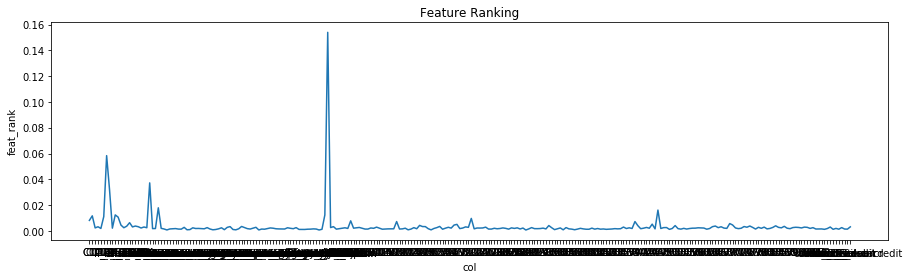

In [81]:
# feature ranking
plt.figure(figsize=(15,4))
sns.lineplot(x='col', y='feat_rank', data=df_feat_rank)
plt.title('Feature Ranking')
plt.show()

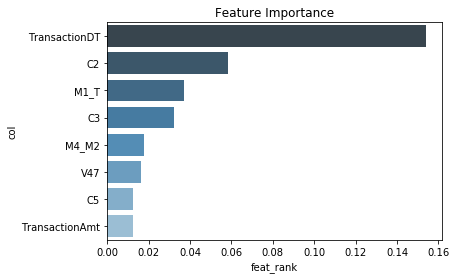

In [89]:
# plt.figure(figsize=(5,10))
sns.barplot(df_feat_rank.feat_rank[0:10], df_feat_rank.col[0:10], palette='Blues_d')
plt.title('Feature Importance')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,4))
sns.kdeplot(df_temp.loc[(df_temp.isFraud==0), 'TransactionAmt'], color='b', shade=True, label='Not Fraud')
# sns.kdeplot(df_temp.loc[(df_temp.isFraud==1), 'TransactionAmt'], color='r', shade=True, label='Fraud')

In [107]:
list_drop_col_1 = list(df_feat_rank[df_feat_rank.feat_rank < .0015]['col'])
list_drop_col_2 = list(df_feat_rank[df_feat_rank.feat_rank < .0015]['col'])
list_drop_col_3 = list(df_feat_rank[df_feat_rank.feat_rank < .01]['col'])

print(len(list_drop_col_1))
print(len(list_drop_col_2))
print(len(list_drop_col_3))

list_drop_col_1

79
79
271


['V294',
 'P_emaildomain_optonline.net',
 'P_emaildomain_netzero.net',
 'V99',
 'V288',
 'M6_T',
 'V98',
 'V311',
 'V286',
 'V320',
 'V318',
 'V313',
 'V120',
 'P_emaildomain_outlook.com',
 'P_emaildomain_comcast.net',
 'V97',
 'V116',
 'P_emaildomain_icloud.com',
 'P_emaildomain_verizon.net',
 'V315',
 'V56',
 'P_emaildomain_live.fr',
 'V78',
 'V27',
 'V11',
 'V110',
 'ProductCD_R',
 'V136',
 'card2_fe',
 'V124',
 'V303',
 'M2_T',
 'V54',
 'P_emaildomain_web.de',
 'P_emaildomain_sc.rr.com',
 'V301',
 'V282',
 'V308',
 'ProductCD_S',
 'V100',
 'addr2_fe',
 'V312',
 'V310',
 'V62',
 'V115',
 'P_emaildomain_suddenlink.net',
 'P_emaildomain_sbcglobal.net',
 'P_emaildomain_mac.com',
 'V134',
 'V305',
 'V306',
 'V317',
 'card4_discover',
 'V32',
 'P_emaildomain_yahoo.es',
 'V50',
 'P_emaildomain_q.com',
 'P_emaildomain_rocketmail.com',
 'P_emaildomain_roadrunner.com',
 'P_emaildomain_gmx.de',
 'P_emaildomain_earthlink.net',
 'P_emaildomain_aol.com',
 'V295',
 'M4_M1',
 'P_emaildomain_fronti

In [ ]:
# predicting on test set w/o PCA
print("Predicting using PCA\n")
y_pred_pca = model_dt_pca_smote.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_dt_pca_smote.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca = model_dt_pca_smote.predict(X_pca)
print("\nTest Results")
print(model_dt_pca_smote.score(X_pca, y))
print(recall_score(y, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca))

In [ ]:
#####################

In [ ]:
print("Variance ratio:")
print(pca.explained_variance_ratio_)
print("\nPrincipal components explained:")
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [ ]:
# applying SMOTE to train set to correct class imbalance
sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
# fitting to residuals created by SMOTE
clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
clf_lr.fit(X_train_res, y_train_res);

In [ ]:
# predicting on test set
y_test_pred = clf_lr.predict(X_test)
print("Validation results")
print(clf_lr.score(X_test, y_test))
print(recall_score(y_test, y_test_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:\n')
print(classification_report(y_test, y_test_pred))

In [ ]:
# predicting on original dataset
y_pred = clf_lr.predict(X)
print("\nTest Results")
print(clf_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))

In [ ]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [ ]:
# logistic regression
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
# clf.predict(X_test)
# clf.score(X_test, y_test)
# 0.7870216903822372 
# 0.8013998429794899 < 60
# 0.5085411973583608 < 1000
# 0.63556873752431 < 60 dropped col_id

In [ ]:
# clf.predict_proba(X_test)

In [ ]:
# # confusion matrix
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

In [ ]:
# print(classification_report(y_test, y_pred))

In [ ]:
# read up on class im balance and correct it. 
# perhaps we can one by one run our model through a decision tree and do one hot encoding for one big 
# categorical column at a time lets say 13,000 unique values, then we can see of the new 13,000 columns we
# have if any actually have predictive value for us. 

In [ ]:
# import statsmodels.api as sm

# # define iv
# iv = X.columns

# # fit the logistic regression function
# logReg = sm.Logit(y_train, X_train)
# answer = logReg.fit()

In [ ]:
# df_result['Fraud']

In [ ]:
# for val in pp.df_train.columns:
#     if (pp.df_train[pp.df_train[val]=='nan'].shape[0]) > 0:
#         print(val)

In [ ]:
# # pp.df_train
# # lets find out which columns are object... 
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val].dtype=='O':
#         list_col_object.append(val)
        
# pp.df_train[list_col_object]
# # for card2, nan was the most commonly seen value... so it imputed that...? 

In [ ]:
# for val in pp.df_train.columns:
#     if pp.df_train[pp.df_train[val]=='nan']

In [ ]:
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val]:
#         list_col_object.append(val)

In [ ]:
# np.sum(pp.df_train[list_col_object].isnull())
# pp.df_train['card2'].unique()
# pp.df_train[df_train['card2']=='nan']

In [ ]:
# sum(np.sum(pp.df_train.isnull()))

In [ ]:
# plt.bar(df_train['V14'])
# sns.barplot(df_train['V196'])
# we need to imput the mode here.. 
# df_train['V14'].mode()
# df_train['V22'].unique()
# for val in col_v:
#     print(val)
#     print(df_train[val].unique())
# we ned to descern what is a 0 1 outcome then impute.

# col = 'V290'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# missing_val = np.sum(df_train[col].isnull())
# print('Missing values: ' + str(missing_val))
# print("REAL VALUE COUNTS: ")
# df_train[col].value_counts().head()

# col = 'card4'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# df_train[col].value_counts()

# col = 'D1'
# series_temp = df_train[col].fillna(df_train[col].mean())
# plt.hist(series_temp);
# df_train['D1'].value_counts()